# Prioritize Email Model

## Goal
The goal of this notebook is to demonstrate a basic model to prioritize emails into three buckets: slow, default, priority.

## Outcome
- Built a logistic regression model to predict email prioritization based on synthetically generated email data.
- This model performance very well on synthetic data (n=500) with near perfect accuracy, indicating that synthetic data is not very realistic and easy to classify, lacking real world varition.
- Model was applied on two real world unlabeld email datasets (Resend spam example) and Enron dataset with visualization below.

## Methodology

### Datasets
Thee datasets were used:
- synthetic labeled data
  - used to train / evaluate model performance. 
  - Generated using the scripts in utils folder and used to catch several use cases: promotional emails, mfa verfication, time sensitive emails, and non urget emails.
- unlabeled spam detection data 
  - provided by Resend
- unlabled enron email data
  -  More details [here](https://technocrat.github.io/_book/the-enron-email-corpus.html)

## Model training
Model was trained using the synthetic data. Even though there were 10k emails in synthetic dataset, only 500 were used to train the model to avoid over training. Since synthetic data was pretty simple and used basic patterns, the model should pick up the key word patterns. Even with limited training data, model performance was greater than 99% accuracy, indicating that synthetic data likely doesn't generalize well to real world. This considered, it will give a good baseline to improve upon as more real data comes in.

As more realistic data is evaluated, the model can be refit to improve.

## Model evaluation
Three models were considered: logistic regression, random forest, and catboost. Given the simple nature of training data, logistic regression performed well enough and was chosen for its simplicity. We can evaluate later to swicth to more complex model as we get more features and labeled real world data




In [1]:
import sys
import os 
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt
import dill
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join(os.getcwd(), "../src/email_prioritizer"))
sys.path.append(module_path)
sys.path.append(str(Path().parent))
from email_prioritizer import EmailPrioritizer


Read in data

In [2]:

list_data_files = [
    '../data/mfa_verification_emails.csv',
    '../data/promotional_emails.csv',
    '../data/urgent_time_sensitive_emails.csv',
    '../data/non_urgent_basic_emails.csv'
]
df_emails_data = pd.concat([pd.read_csv(file) for file in list_data_files], ignore_index=True)
df_emails_data.shape

(10000, 2)

In [3]:
num_holdout = 1000
df_emails_train, df_emails_holdout = train_test_split(df_emails_data, test_size=(num_holdout*1./df_emails_data.shape[0]), random_state=42)
print(df_emails_holdout.query("label=='Prioritize'").reset_index().email.iloc[0])
df_emails_train.head()

From: operations@ops.company.com
Subject: URGENT: Payment Overdue: Invoice INV-907918
Hello Casey Garcia, This is a final reminder: account verification must be completed by Oct 25 at 06:44 AM UTC. Pay invoice INV-780261 immediately to avoid service interruption. Sincerely, Billing


,email,label
4896,From: billing@billing.example.com\nSubject: UR...,Prioritize
4782,From: operations@security.company.com\nSubject...,Prioritize
1496,From: offers@doordash.com\nSubject: Member exc...,Slow
1957,From: sales@target.com\nSubject: Your deal is ...,Slow
9171,From: alex@company.com\nSubject: Following up ...,Default


In [4]:
# parse features and labels
x_col = 'email'
y_col = 'label'
X = df_emails_train[x_col]
y = df_emails_train[y_col]
X_holdout = df_emails_holdout[x_col]
y_holdout = df_emails_holdout[y_col]
test_size=.9444
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(f"Training size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# display sender, subject, and body data
pattern = r"From:\s*(?P<From>.+)\nSubject:\s*(?P<Subject>.+)\n(?P<Body>.+)"
df_email_holdout = X_holdout.str.extract(pattern, flags=re.DOTALL)
df_email_holdout

Training size: 500, Test size: 8500


,From,Subject,Body
6252,alex@mail.com,Quick question about marketing materials,"Hey Jess, Here’s a quick summary of where we l..."
4684,operations@ops.company.com,URGENT: Payment Overdue: Invoice INV-907918,"Hello Casey Garcia, This is a final reminder: ..."
1731,no-reply@airbnb.com,Early access: 30% off new arrivals!,Take 30% off and enjoy free shipping on select...
4742,finance@alerts.bank.com,URGENT: Security Alert: Respond by 2025-10-24 ...,"Hello Josh Clark, Reference: case #7861466. Co..."
4521,operations@billing.example.com,Escalation: server outage ticket needs your ap...,We need a short confirmation (Yes/No) within 6...
...,...,...,...
3921,newsletter@costco.com,Exclusive online offer: 25% off everything!,Check out our latest deals — 25% off selected ...
6685,alex@teamhub.io,Quick question about the Q3 project,"Hello Jamie, Everything seems to be on track a..."
3194,no-reply@airbnb.com,Spring sale is here! 30% off select items!,Your personalized deal: 30% off selected items...
1941,promotions@nike.com,Your deal is here: 20% off selected items!,Spring into savings with 20% off select products.


fit email prioritizer on training data and measure performance

In [5]:
detector = EmailPrioritizer(model_type="logistic")
detector.fit(X_train, y_train, cv=3)
detector.evaluate(X_test, y_test)
df_results = pd.DataFrame({
    'email_from': df_email_holdout.From,
    'email_subject': df_email_holdout.Subject,
    'email_body': df_email_holdout.Body,
    'prediction': detector.predict(X_holdout),
    'true_label': y_holdout,
    'correct': detector.predict(X_holdout) == y_holdout,
    'score_default': detector.predict_proba(X_holdout)[:,0],
    'score_prioritize': detector.predict_proba(X_holdout)[:,1],
    'score_slow': detector.predict_proba(X_holdout)[:,2],
})
df_results

Running GridSearchCV for logistic...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best cross-val f1 score: 1.000
Best parameters: {'model__C': 0.1}

Evaluation Report:
              precision    recall  f1-score   support

     Default       1.00      1.00      1.00      4244
  Prioritize       1.00      1.00      1.00      1674
        Slow       1.00      1.00      1.00      2582

    accuracy                           1.00      8500
   macro avg       1.00      1.00      1.00      8500
weighted avg       1.00      1.00      1.00      8500

Accuracy: 1.0
F1 Score: 1.0


,email_from,email_subject,email_body,prediction,true_label,correct,score_default,score_prioritize,score_slow
6252,alex@mail.com,Quick question about marketing materials,"Hey Jess, Here’s a quick summary of where we l...",Default,Default,True,0.833174,0.072915,0.093912
4684,operations@ops.company.com,URGENT: Payment Overdue: Invoice INV-907918,"Hello Casey Garcia, This is a final reminder: ...",Prioritize,Prioritize,True,0.210559,0.628302,0.161139
1731,no-reply@airbnb.com,Early access: 30% off new arrivals!,Take 30% off and enjoy free shipping on select...,Slow,Slow,True,0.177824,0.223684,0.598492
4742,finance@alerts.bank.com,URGENT: Security Alert: Respond by 2025-10-24 ...,"Hello Josh Clark, Reference: case #7861466. Co...",Prioritize,Prioritize,True,0.169459,0.666958,0.163583
4521,operations@billing.example.com,Escalation: server outage ticket needs your ap...,We need a short confirmation (Yes/No) within 6...,Prioritize,Prioritize,True,0.192651,0.646369,0.160980
...,...,...,...,...,...,...,...,...,...
3921,newsletter@costco.com,Exclusive online offer: 25% off everything!,Check out our latest deals — 25% off selected ...,Slow,Slow,True,0.190306,0.128548,0.681146
6685,alex@teamhub.io,Quick question about the Q3 project,"Hello Jamie, Everything seems to be on track a...",Default,Default,True,0.845613,0.067461,0.086926
3194,no-reply@airbnb.com,Spring sale is here! 30% off select items!,Your personalized deal: 30% off selected items...,Slow,Slow,True,0.128368,0.151655,0.719977
1941,promotions@nike.com,Your deal is here: 20% off selected items!,Spring into savings with 20% off select products.,Slow,Slow,True,0.144881,0.109942,0.745177


Save model to dill file. Model will be used by streamlit 

In [6]:

save_model = False
model = detector.pipeline

if save_model:
    os.chdir('../')
    filename = './finalized_model_lr.dill'
    print(os.getcwd())
    with open(filename, 'wb') as file:
        dill.dump(model, file, recurse=True)
    
    with open("./finalized_model_lr.dill", "rb") as f:
        model = dill.load(f)
        print(model)
    os.chdir('./notebooks')  # change back to notebooks directory

Generate learning curve


=== Training with first 10 samples ===
Running GridSearchCV for logistic...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best cross-val f1 score: 0.606
Best parameters: {'model__C': 10}


/Users/joshsherfey/Documents/interview/resend/EmailPrioritizationClassifier/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Accuracy at 10 samples: 0.700

=== Training with first 20 samples ===
Running GridSearchCV for logistic...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best cross-val f1 score: 0.604
Best parameters: {'model__C': 1}
Accuracy at 20 samples: 0.858

=== Training with first 30 samples ===
Running GridSearchCV for logistic...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best cross-val f1 score: 0.965
Best parameters: {'model__C': 10}
Accuracy at 30 samples: 0.954

=== Training with first 40 samples ===
Running GridSearchCV for logistic...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best cross-val f1 score: 0.948
Best parameters: {'model__C': 10}
Accuracy at 40 samples: 0.995

=== Training with first 50 samples ===
Running GridSearchCV for logistic...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best cross-val f1 score: 1.000
Best parameters: {'model__C': 1}
Accuracy at 50 samples: 0.999

=== Training with first 60 samples ===


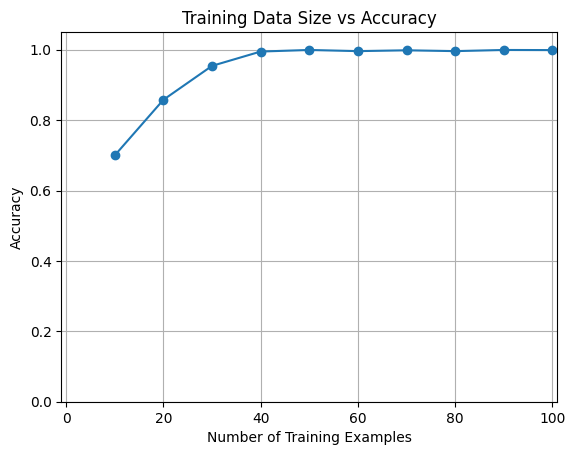

In [7]:
from sklearn.metrics import accuracy_score
training_sizes = list(range(10, 110, 10))  # 10, 20, ..., 100
results = []

for n in training_sizes:
    print(f"\n=== Training with first {n} samples ===")

    # Take first n samples
    X_subset = X_train.sample(n=n, random_state=n)
    y_subset = y_train.sample(n=n, random_state=n)

    # Train model
    model = EmailPrioritizer(model_type="logistic")   # or "random_forest" or "catboost"
    model.fit(X_subset, y_subset, cv=3)               # reduce CV for speed on tiny samples

    # Evaluate on full test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append((n, acc))
    print(f"Accuracy at {n} samples: {acc:.3f}")

# Convert to DataFrame for plotting
results_df = pd.DataFrame(results, columns=["n_train_samples", "accuracy"])
print("\nLearning Curve:")
print(results_df)

plt.figure()
plt.plot(results_df["n_train_samples"], results_df["accuracy"], marker='o')
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.xlim(-1,101)
plt.title("Training Data Size vs Accuracy")
plt.grid(True)
plt.show()

Plot model performance using the below utility method. 
- TODO: Move utily method to separate utils file

In [ ]:
def plot_model_performance(prioritizer, X_test, y_test):
    if prioritizer.pipeline is None:
        raise ValueError("Model must be trained before plotting performance.")

    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    model = prioritizer.pipeline.named_steps["model"]
    features = prioritizer.pipeline.named_steps['features']
    y_pred = prioritizer.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ---------- Confusion Matrix ----------
    # Align label space automatically
    classes = prioritizer.pipeline.named_steps['model'].classes_
    cm = confusion_matrix(y_test, y_pred, labels=classes)

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(
        cmap="Blues", values_format="d"
    )

    # cm = confusion_matrix(y_test, y_pred)
    # ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # ---------- If model supports predict_proba ----------
    if not hasattr(model, "predict_proba"):
        print("Model does not support probability scores → skipping PR and ROC curves.")
        return

    y_proba = prioritizer.predict_proba(X_test)

    # classes = np.unique(y_test)

    # ---------- Binary Case ----------
    if len(classes) == 2:
        y_score = y_proba[:, 1]

        precision, recall, _ = precision_recall_curve(y_test, y_score)
        plt.plot(recall, precision, linewidth=2)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall Curve")
        plt.grid(True)
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    # ---------- Multi-Class Case ----------
    else:
        # Binarize y for one-vs-rest PR + ROC
        y_test_bin = label_binarize(y_test, classes=classes)

        # Precision-Recall (macro)
        plt.figure()
        for i, cls in enumerate(classes):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
            plt.plot(recall, precision, label=f"Class {cls}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall Curve (One-vs-Rest)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # ROC (one-vs-rest)
        plt.figure()
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {cls} (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (One-vs-Rest)")
        plt.legend()
        plt.grid(True)
        plt.show()
    

    print("\n\n=== Misclassified Examples ===")

    # Identify misclassified indices
    mis_idx = np.where(y_pred != y_test)[0]
    print(mis_idx)
    if len(mis_idx) == 0:
        print("✅ No misclassifications! Nothing to debug.")
        return

    print(f"\n🔍 Found {len(mis_idx)} misclassified emails.\n")

    # Extract the 3 TF-IDF vectorizers
    sender_vec = features.transformer_list[0][1].named_steps['tfidf']
    subject_vec = features.transformer_list[1][1].named_steps['tfidf']
    body_vec = features.transformer_list[2][1].named_steps['tfidf']

    # Build combined feature names list
    feature_names = np.concatenate([
        sender_vec.get_feature_names_out(),
        subject_vec.get_feature_names_out(),
        body_vec.get_feature_names_out(),
    ])

    # Convert X_test into model feature space
    split = prioritizer.pipeline.named_steps["splitter"].transform(X_test)
    X_vec = features.transform(split)

    rows = []
    for idx in mis_idx:
        email_text = X_test[idx]
        true = y_test[idx]
        pred = y_pred[idx]
        confidence = y_proba[idx].max() if y_proba is not None else None

        # Extract contribution scores only for linear models
        if hasattr(model, "coef_"):
            pred_class = pred
            coef = model.coef_[list(model.classes_).index(pred_class)]
            contrib = X_vec[idx].toarray()[0] * coef
            top_n = 5
            top_pos = contrib.argsort()[-top_n:][::-1]
            explanation = [(feature_names[i], contrib[i]) for i in top_pos]
        else:
            explanation = "N/A (Model is not linear)"

        rows.append({
            "true_label": true,
            "pred_label": pred,
            "confidence": confidence,
            "top_contributing_words": explanation,
            "text": email_text
        })

    df_debug = pd.DataFrame(rows)
    pd.set_option('display.max_colwidth', None)

    print("\n=== Misclassified Examples with Explanations ===")
    print(df_debug[["true_label", "pred_label", "confidence", "top_contributing_words", "text"]])

    return df_debug


Explain model reasoning for 3 predictions

In [9]:
test_idx = 10
email = X_test.iloc[test_idx]
label = y_test.iloc[test_idx]
print("Label: ", label)
print(email)
EmailPrioritizer.explain_single_prediction(email_text=email, pipeline=detector.pipeline)

Label:  Default
From: riley@mail.com
Subject: Feedback on weekly sync
Hey Josh, Let me know if anything changes. Not expecting a reply right away — just wanted to share. Talk soon, Avery

Predicted Class: Default (p=78%)

Top Positive Contributions (pushing toward prediction):
 feature  contribution
    mail      0.334455
   riley      0.219796
feedback      0.133094
    sync      0.071958
  weekli      0.071958

Top Negative Contributions (pushing against prediction):
feature  contribution
    com     -0.080513
account     -0.000000
  limit     -0.000000


('Default',
       feature  contribution
 41       mail      0.334455
 64      riley      0.219796
 122  feedback      0.133094
 207      sync      0.071958
 225    weekli      0.071958,
      feature  contribution
 18       com     -0.080513
 0    account     -0.000000
 433    limit     -0.000000,
 np.float64(1.1662786600935773))

In [10]:
test_idx = 20
email = X_test.iloc[test_idx]
label = y_test.iloc[test_idx]
print("Label: ", label)
print(email)
EmailPrioritizer.explain_single_prediction(email_text=email, pipeline=detector.pipeline)

Label:  Prioritize
From: verify@airbnb.com
Subject: Confirm your login
Use 402020 to verify your account. This code will expire in 10 minutes.

Predicted Class: Prioritize (p=67%)

Top Positive Contributions (pushing toward prediction):
feature  contribution
confirm      0.258866
  login      0.234456
   code      0.187567
account      0.118170
  expir      0.101183

Top Negative Contributions (pushing against prediction):
feature  contribution
 airbnb     -0.040069
account      0.000000
  linux      0.000000


('Prioritize',
      feature  contribution
 103  confirm      0.258866
 144    login      0.234456
 299     code      0.187567
 230  account      0.118170
 355    expir      0.101183,
      feature  contribution
 1     airbnb     -0.040069
 0    account      0.000000
 435    linux      0.000000,
 np.float64(1.207784183956747))

In [11]:
test_idx = 21
email = X_test.iloc[test_idx]
label = y_test.iloc[test_idx]
print("Label: ", label)
print(email)
EmailPrioritizer.explain_single_prediction(email_text=email, pipeline=detector.pipeline)

Label:  Slow
From: rewards@starbucks.com
Subject: Hot picks: 40% off today only!
Unlock 40% off your order today — limited time offer!

Predicted Class: Slow (p=72%)

Top Positive Contributions (pushing toward prediction):
feature  contribution
rewards      0.151554
  today      0.142296
   pick      0.093075
    hot      0.092730
  today      0.092303

Top Negative Contributions (pushing against prediction):
feature  contribution
account          -0.0
   link          -0.0
  linux          -0.0


('Slow',
      feature  contribution
 63   rewards      0.151554
 212    today      0.142296
 162     pick      0.093075
 131      hot      0.092730
 620    today      0.092303,
      feature  contribution
 0    account          -0.0
 434     link          -0.0
 435    linux          -0.0,
 np.float64(0.9702725910082917))

Evaluate the performance of model. only 30 instances provided since the model perfectly predicts data after 40 instances.

Running GridSearchCV for logistic...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best cross-val f1 score: 1.000
Best parameters: {'model__C': 10}

Evaluation Report:
              precision    recall  f1-score   support

     Default       0.98      1.00      0.99      4244
  Prioritize       1.00      0.90      0.95      1674
        Slow       0.95      0.99      0.97      2582

    accuracy                           0.98      8500
   macro avg       0.98      0.96      0.97      8500
weighted avg       0.98      0.98      0.98      8500

Accuracy: 0.976
F1 Score: 0.975701496019072

Classification Report:
              precision    recall  f1-score   support

     Default       0.98      1.00      0.99      4244
  Prioritize       1.00      0.90      0.95      1674
        Slow       0.95      0.99      0.97      2582

    accuracy                           0.98      8500
   macro avg       0.98      0.96      0.97      8500
weighted avg       0.98      0.98      0.9

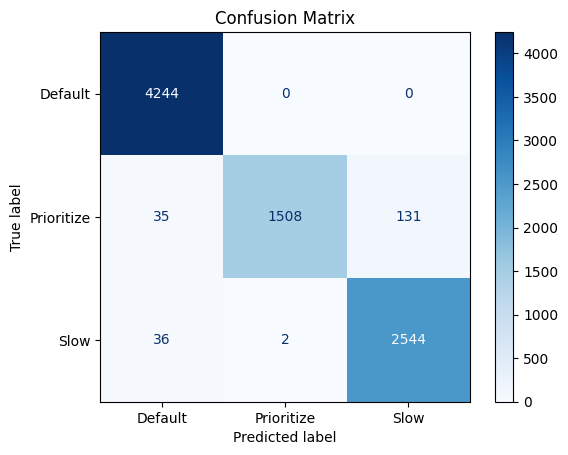

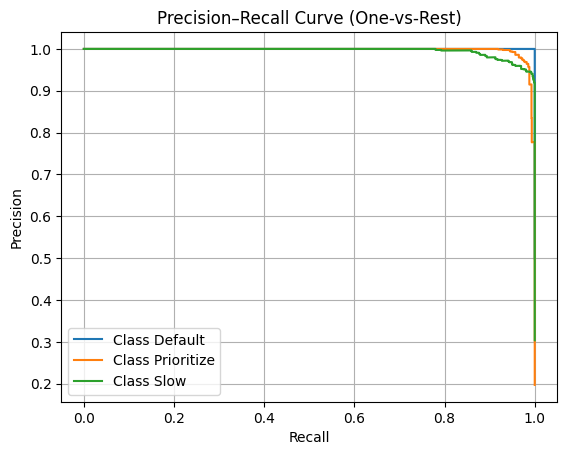

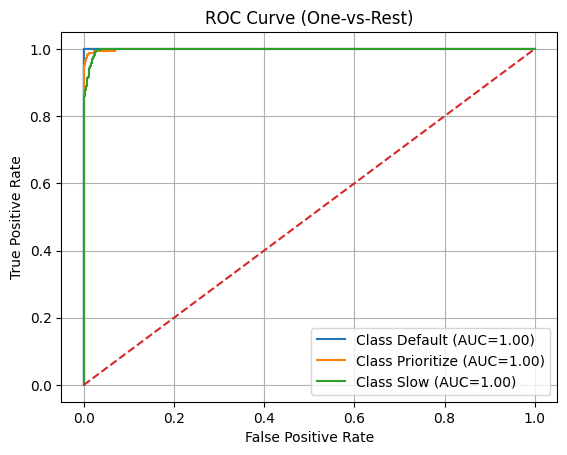



=== Misclassified Examples ===
[  85  102  103  239  352  353  355  397  401  490  568  576  630  669
  670  753  772  786  819  904  972  983 1029 1031 1202 1251 1258 1289
 1330 1335 1432 1434 1522 1534 1538 1581 1647 1666 1724 1728 1807 1844
 1852 1883 1966 2021 2042 2054 2088 2114 2132 2142 2170 2207 2244 2422
 2449 2490 2493 2505 2515 2518 2565 2618 2620 2634 2676 2734 2748 2807
 2842 2941 3073 3226 3254 3319 3395 3434 3478 3518 3570 3627 3654 3698
 3735 3809 3832 3834 3913 3939 3973 3995 4023 4046 4158 4170 4212 4266
 4353 4356 4358 4368 4376 4526 4528 4540 4545 4591 4593 4595 4602 4673
 4811 4824 4918 4929 4988 5001 5002 5022 5023 5041 5046 5066 5192 5295
 5378 5410 5606 5637 5644 5684 5736 5747 5836 5875 5906 5933 5989 6098
 6121 6124 6180 6211 6228 6360 6394 6461 6540 6591 6596 6609 6669 6710
 6711 6716 6750 6847 6923 6937 6941 7007 7017 7043 7069 7105 7114 7128
 7152 7165 7209 7321 7360 7371 7379 7430 7433 7474 7488 7540 7742 7753
 7759 7813 7817 7857 7903 7919 7988 8005 800

,email_from,email_subject,email_body,prediction,true_label,correct,score_default,score_prioritize,score_slow
6252,alex@mail.com,Quick question about marketing materials,"Hey Jess, Here’s a quick summary of where we left things. No major updates, just sharing where things stand. Thanks again for taking the time to review. Best, Taylor",Default,Default,True,0.810041,0.074950,0.115009
4684,operations@ops.company.com,URGENT: Payment Overdue: Invoice INV-907918,"Hello Casey Garcia, This is a final reminder: account verification must be completed by Oct 25 at 06:44 AM UTC. Pay invoice INV-780261 immediately to avoid service interruption. Sincerely, Billing",Prioritize,Prioritize,True,0.310269,0.560809,0.128922
1731,no-reply@airbnb.com,Early access: 30% off new arrivals!,Take 30% off and enjoy free shipping on select items.,Slow,Slow,True,0.178072,0.063470,0.758458
4742,finance@alerts.bank.com,URGENT: Security Alert: Respond by 2025-10-24 07:59 UTC,"Hello Josh Clark, Reference: case #7861466. Contact Casey Clark at +1-507-837-1394 for immediate assistance. Are you able to provide the requested information before Oct 24 at 03:14 AM UTC? This matter is high priority—reach out to Casey Clark if you have any blockers. Thank you, Operations",Prioritize,Prioritize,True,0.191350,0.687112,0.121538
4521,operations@billing.example.com,Escalation: server outage ticket needs your approval,"We need a short confirmation (Yes/No) within 6 hours so we can proceed. Can you confirm you will complete this by Oct 26 at 02:44 PM UTC? This is a final reminder: refund authorization must be completed by Oct 26 at 02:44 PM UTC. Confirm receipt and action on refund authorization within 6 hours. Regards, Operations",Prioritize,Prioritize,True,0.118128,0.812060,0.069812
...,...,...,...,...,...,...,...,...,...
3921,newsletter@costco.com,Exclusive online offer: 25% off everything!,Check out our latest deals — 25% off selected items.,Slow,Slow,True,0.288678,0.163535,0.547787
6685,alex@teamhub.io,Quick question about the Q3 project,"Hello Jamie, Everything seems to be on track at the moment. It’s been a while since we last talked about the Q3 project. No need to reply right away. Talk soon, Riley",Default,Default,True,0.958564,0.018366,0.023071
3194,no-reply@airbnb.com,Spring sale is here! 30% off select items!,Your personalized deal: 30% off selected items just for you.,Slow,Slow,True,0.044706,0.024898,0.930397
1941,promotions@nike.com,Your deal is here: 20% off selected items!,Spring into savings with 20% off select products.,Slow,Slow,True,0.062592,0.053649,0.883759


In [12]:
num_train_samples = 30
detector = EmailPrioritizer(model_type="logistic")
detector.fit(
    X_train.iloc[:num_train_samples], 
    y_train.iloc[:num_train_samples], 
    cv=3
)
detector.evaluate(X_test, y_test)
df_results = pd.DataFrame({
    'email_from': df_email_holdout.From,
    'email_subject': df_email_holdout.Subject,
    'email_body': df_email_holdout.Body,
    'prediction': detector.predict(X_holdout),
    'true_label': y_holdout,
    'correct': detector.predict(X_holdout) == y_holdout,
    'score_default': detector.predict_proba(X_holdout)[:,0],
    'score_prioritize': detector.predict_proba(X_holdout)[:,1],
    'score_slow': detector.predict_proba(X_holdout)[:,2],
})
plot_model_performance(detector, X_test, y_test)
df_results

#### Random Forest
Utilize Random Forest instead of logistic regression. 
- Outcome: Not enough useful training data to see quantifyable benefits

In [13]:
detector_rf = EmailPrioritizer(model_type="random_forest")
detector_rf.fit(X_train, y_train, cv=3)
detector_rf.evaluate(X_test, y_test)
df_results_rf = pd.DataFrame({
    'email_from': df_email_holdout.From,
    'email_subject': df_email_holdout.Subject,
    'email_body': df_email_holdout.Body,
    'prediction': detector_rf.predict(X_holdout),
    'true_label': y_holdout,
    'correct': detector_rf.predict(X_holdout) == y_holdout,
    'score_default': detector_rf.predict_proba(X_holdout)[:,0],
    'score_prioritize': detector_rf.predict_proba(X_holdout)[:,1],
    'score_slow': detector_rf.predict_proba(X_holdout)[:,2],
})
df_results_rf

Running GridSearchCV for random_forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best cross-val f1 score: 1.000
Best parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Evaluation Report:
              precision    recall  f1-score   support

     Default       1.00      1.00      1.00      4244
  Prioritize       1.00      0.99      0.99      1674
        Slow       0.99      1.00      1.00      2582

    accuracy                           1.00      8500
   macro avg       1.00      1.00      1.00      8500
weighted avg       1.00      1.00      1.00      8500

Accuracy: 0.9976470588235294
F1 Score: 0.9976433322573789


,email_from,email_subject,email_body,prediction,true_label,correct,score_default,score_prioritize,score_slow
6252,alex@mail.com,Quick question about marketing materials,"Hey Jess, Here’s a quick summary of where we left things. No major updates, just sharing where things stand. Thanks again for taking the time to review. Best, Taylor",Default,Default,True,0.935725,0.021530,0.042745
4684,operations@ops.company.com,URGENT: Payment Overdue: Invoice INV-907918,"Hello Casey Garcia, This is a final reminder: account verification must be completed by Oct 25 at 06:44 AM UTC. Pay invoice INV-780261 immediately to avoid service interruption. Sincerely, Billing",Prioritize,Prioritize,True,0.031164,0.922467,0.046369
1731,no-reply@airbnb.com,Early access: 30% off new arrivals!,Take 30% off and enjoy free shipping on select items.,Slow,Slow,True,0.221707,0.024827,0.753466
4742,finance@alerts.bank.com,URGENT: Security Alert: Respond by 2025-10-24 07:59 UTC,"Hello Josh Clark, Reference: case #7861466. Contact Casey Clark at +1-507-837-1394 for immediate assistance. Are you able to provide the requested information before Oct 24 at 03:14 AM UTC? This matter is high priority—reach out to Casey Clark if you have any blockers. Thank you, Operations",Prioritize,Prioritize,True,0.021422,0.904334,0.074244
4521,operations@billing.example.com,Escalation: server outage ticket needs your approval,"We need a short confirmation (Yes/No) within 6 hours so we can proceed. Can you confirm you will complete this by Oct 26 at 02:44 PM UTC? This is a final reminder: refund authorization must be completed by Oct 26 at 02:44 PM UTC. Confirm receipt and action on refund authorization within 6 hours. Regards, Operations",Prioritize,Prioritize,True,0.001604,0.961594,0.036803
...,...,...,...,...,...,...,...,...,...
3921,newsletter@costco.com,Exclusive online offer: 25% off everything!,Check out our latest deals — 25% off selected items.,Slow,Slow,True,0.029971,0.023267,0.946762
6685,alex@teamhub.io,Quick question about the Q3 project,"Hello Jamie, Everything seems to be on track at the moment. It’s been a while since we last talked about the Q3 project. No need to reply right away. Talk soon, Riley",Default,Default,True,0.967191,0.012793,0.020016
3194,no-reply@airbnb.com,Spring sale is here! 30% off select items!,Your personalized deal: 30% off selected items just for you.,Slow,Slow,True,0.020584,0.026783,0.952634
1941,promotions@nike.com,Your deal is here: 20% off selected items!,Spring into savings with 20% off select products.,Slow,Slow,True,0.014962,0.019961,0.965076


#### Cat Boost
Utilize CatBoost instead of logistic regression. 
- Outcome: Not enough useful training data to see quantifyable benefits

In [14]:
detector_cb = EmailPrioritizer(model_type="catboost")
detector_cb.fit(X_train, y_train, cv=3)
detector_cb.evaluate(X_test, y_test)
df_results_cb = pd.DataFrame({
    'email_from': df_email_holdout.From,
    'email_subject': df_email_holdout.Subject,
    'email_body': df_email_holdout.Body,
    'prediction': detector.predict(X_holdout),
    'true_label': y_holdout,
    'correct': detector.predict(X_holdout) == y_holdout,
    'score_default': detector_cb.predict_proba(X_holdout)[:,0],
    'score_prioritize': detector_cb.predict_proba(X_holdout)[:,1],
    'score_slow': detector_cb.predict_proba(X_holdout)[:,2],
})
df_results_cb

Running GridSearchCV for catboost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best cross-val f1 score: 0.986
Best parameters: {'model__depth': 6, 'model__iterations': 200, 'model__learning_rate': 0.1}

Evaluation Report:
              precision    recall  f1-score   support

     Default       0.99      1.00      1.00      4244
  Prioritize       1.00      0.97      0.99      1674
        Slow       0.99      1.00      1.00      2582

    accuracy                           0.99      8500
   macro avg       1.00      0.99      0.99      8500
weighted avg       0.99      0.99      0.99      8500

Accuracy: 0.9947058823529412
F1 Score: 0.9946788090095878


,email_from,email_subject,email_body,prediction,true_label,correct,score_default,score_prioritize,score_slow
6252,alex@mail.com,Quick question about marketing materials,"Hey Jess, Here’s a quick summary of where we left things. No major updates, just sharing where things stand. Thanks again for taking the time to review. Best, Taylor",Default,Default,True,0.996128,0.000630,0.003242
4684,operations@ops.company.com,URGENT: Payment Overdue: Invoice INV-907918,"Hello Casey Garcia, This is a final reminder: account verification must be completed by Oct 25 at 06:44 AM UTC. Pay invoice INV-780261 immediately to avoid service interruption. Sincerely, Billing",Prioritize,Prioritize,True,0.007121,0.979690,0.013190
1731,no-reply@airbnb.com,Early access: 30% off new arrivals!,Take 30% off and enjoy free shipping on select items.,Slow,Slow,True,0.005984,0.003856,0.990160
4742,finance@alerts.bank.com,URGENT: Security Alert: Respond by 2025-10-24 07:59 UTC,"Hello Josh Clark, Reference: case #7861466. Contact Casey Clark at +1-507-837-1394 for immediate assistance. Are you able to provide the requested information before Oct 24 at 03:14 AM UTC? This matter is high priority—reach out to Casey Clark if you have any blockers. Thank you, Operations",Prioritize,Prioritize,True,0.022266,0.947107,0.030627
4521,operations@billing.example.com,Escalation: server outage ticket needs your approval,"We need a short confirmation (Yes/No) within 6 hours so we can proceed. Can you confirm you will complete this by Oct 26 at 02:44 PM UTC? This is a final reminder: refund authorization must be completed by Oct 26 at 02:44 PM UTC. Confirm receipt and action on refund authorization within 6 hours. Regards, Operations",Prioritize,Prioritize,True,0.004094,0.989346,0.006560
...,...,...,...,...,...,...,...,...,...
3921,newsletter@costco.com,Exclusive online offer: 25% off everything!,Check out our latest deals — 25% off selected items.,Slow,Slow,True,0.004937,0.003441,0.991622
6685,alex@teamhub.io,Quick question about the Q3 project,"Hello Jamie, Everything seems to be on track at the moment. It’s been a while since we last talked about the Q3 project. No need to reply right away. Talk soon, Riley",Default,Default,True,0.995689,0.000919,0.003392
3194,no-reply@airbnb.com,Spring sale is here! 30% off select items!,Your personalized deal: 30% off selected items just for you.,Slow,Slow,True,0.004357,0.003142,0.992501
1941,promotions@nike.com,Your deal is here: 20% off selected items!,Spring into savings with 20% off select products.,Slow,Slow,True,0.007147,0.004335,0.988518


- Outcome: Use logistic regression since this is the simplest model and training data is limited

### Apply Model to new datasets

#### Resend dataset (unlabeled)


In [15]:
df_emails_spam = pd.read_csv('../data/email_classification_dataset_resend.csv').sample(n=500, random_state=42)
pattern = r"From:\s*(?P<From>.+)\nSubject:\s*(?P<Subject>.+)\n(?P<Body>.+)"
df_emails_spam_parsed = df_emails_spam.email.str.extract(pattern, flags=re.DOTALL)

print(pd.read_csv('../data/email_classification_dataset_resend.csv').iloc[4684].email)

df_emails_spam_parsed.head()

From: noreply@softwareupdates.com
Subject: Meeting Reminder: Project Alpha

We value your feedback! Please take a few moments to complete a short survey about your recent purchase from us. Your input helps us improve. Take survey: [link to survey]. Thank you, Retail Feedback Team


,From,Subject,Body
6252,friend@personalmail.net,Catching Up - How are you?\n,"Thank you for your order #6789. Your items will be shipped within 2 business days. You can track your order here: [link to legitimate tracking page]. Best regards, Legit Company Support"
4684,noreply@softwareupdates.com,Meeting Reminder: Project Alpha\n,"We value your feedback! Please take a few moments to complete a short survey about your recent purchase from us. Your input helps us improve. Take survey: [link to survey]. Thank you, Retail Feedback Team"
1731,friend@personalmail.net,Photos from the Weekend Trip\n,"Hi everyone, I've uploaded the photos from our weekend trip to the shared drive. You can view them here: [link to cloud storage]. Let me know what you think! Best, [Your Name]"
4742,deals@best-offers.xyz,Verify Your Bank Details Immediately\n,Invest in our revolutionary new platform and earn guaranteed high returns. Learn more: [link]
4521,team@projectmanagement.com,Meeting Reminder: Project Alpha\n,"Thank you for your order #6789. Your items will be shipped within 2 business days. You can track your order here: [link to legitimate tracking page]. Best regards, Legit Company Support"


After reviewing this data, it seems that the subjects don't match the body, which may result in inaccurate predictions. I don't think these are real emails.

In [16]:

prediction_proba = detector.predict_proba(df_emails_spam['email'])
df_results_resend = pd.DataFrame({
    'email_sender': df_emails_spam_parsed['From'],
    'email_subject': df_emails_spam_parsed['Subject'],
    'email_body': df_emails_spam_parsed['Body'],
    'prediction': detector.predict(df_emails_spam['email']),
    'score_default': prediction_proba[:,0],
    'score_prioritize': prediction_proba[:,1],
    'score_slow': prediction_proba[:,2],
})
df_results_resend

,email_sender,email_subject,email_body,prediction,score_default,score_prioritize,score_slow
6252,friend@personalmail.net,Catching Up - How are you?\n,"Thank you for your order #6789. Your items will be shipped within 2 business days. You can track your order here: [link to legitimate tracking page]. Best regards, Legit Company Support",Default,0.546925,0.170035,0.283040
4684,noreply@softwareupdates.com,Meeting Reminder: Project Alpha\n,"We value your feedback! Please take a few moments to complete a short survey about your recent purchase from us. Your input helps us improve. Take survey: [link to survey]. Thank you, Retail Feedback Team",Default,0.668723,0.135506,0.195771
1731,friend@personalmail.net,Photos from the Weekend Trip\n,"Hi everyone, I've uploaded the photos from our weekend trip to the shared drive. You can view them here: [link to cloud storage]. Let me know what you think! Best, [Your Name]",Default,0.723147,0.109094,0.167758
4742,deals@best-offers.xyz,Verify Your Bank Details Immediately\n,Invest in our revolutionary new platform and earn guaranteed high returns. Learn more: [link],Slow,0.301181,0.105377,0.593442
4521,team@projectmanagement.com,Meeting Reminder: Project Alpha\n,"Thank you for your order #6789. Your items will be shipped within 2 business days. You can track your order here: [link to legitimate tracking page]. Best regards, Legit Company Support",Default,0.640551,0.169880,0.189569
...,...,...,...,...,...,...,...
5170,survey@retailfeedback.com,Weekly Newsletter - Latest Updates\n,"This is an automated notification regarding an important software update for your system. Please ensure your software is updated to the latest version to maintain security and performance. Learn more: [link to official update page]. Regards, Software Updates",Default,0.469906,0.243646,0.286447
7205,survey@retailfeedback.com,Photos from the Weekend Trip\n,"Hey [Friend's Name], it's been a while! How have you been? I was thinking about [recent event/topic]. Let's catch up soon! Cheers, [Your Name]",Default,0.532591,0.155843,0.311566
2522,info@customerservice.co,Team Stand-up at 10 AM\n,"Good morning, everyone. Just a quick reminder for our daily stand-up meeting at 10 AM. Please be ready to share your progress and any blockers. Thanks, Project Manager",Default,0.543719,0.141880,0.314400
2215,friend@personalmail.net,Meeting Reminder: Project Alpha\n,"Thank you for reaching out regarding [your inquiry]. We have reviewed your request and will get back to you within 24 hours with a detailed response. Sincerely, Customer Service Team",Default,0.737383,0.127993,0.134624


Show top predictions for prioritize, default, and slow

In [17]:
df_results_resend.sort_values('score_prioritize', ascending=False).head(10)

,email_sender,email_subject,email_body,prediction,score_default,score_prioritize,score_slow
6552,support@secure-login.com,Congratulations! You've Won a Free iPhone!\n,"We detected suspicious login attempts on your account. For your security, please update your password immediately: [link]",Prioritize,0.176817,0.695849,0.127334
970,support@secure-login.com,URGENT: Your Account Has Been Compromised!\n,Urgent security notification! A login from an unrecognized device was detected. Review activity: [link],Prioritize,0.173510,0.695089,0.131401
2018,admin@bank-verify.org,Important Security Alert: Login from New Device\n,"We detected suspicious login attempts on your account. For your security, please update your password immediately: [link]",Prioritize,0.252184,0.670390,0.077427
33,security@alert-system.ru,Unclaimed Funds Await You\n,"Dear customer, your account has been temporarily suspended due to unusual activity. Please click here to verify your details: [link]",Prioritize,0.209919,0.667013,0.123068
2124,security@alert-system.ru,Important Security Alert: Login from New Device\n,Invest in our revolutionary new platform and earn guaranteed high returns. Learn more: [link],Prioritize,0.215145,0.640542,0.144313
7968,support@secure-login.com,Exclusive Investment Opportunity - High Returns!\n,"Dear customer, your account has been temporarily suspended due to unusual activity. Please click here to verify your details: [link]",Prioritize,0.212989,0.622576,0.164435
14,support@legitcompany.com,Photos from the Weekend Trip\n,"Please find attached your invoice for the services rendered in June. The total amount due is $X.XX. Payment is due by [Date]. If you have any questions, please reply to this email. Thank you, Accounts Department",Prioritize,0.229201,0.620488,0.150311
4367,support@legitcompany.com,Invoice for Services Rendered\n,"Please find attached your invoice for the services rendered in June. The total amount due is $X.XX. Payment is due by [Date]. If you have any questions, please reply to this email. Thank you, Accounts Department",Prioritize,0.229201,0.620488,0.150311
9411,support@legitcompany.com,Your Order #6789 Confirmed\n,"Please find attached your invoice for the services rendered in June. The total amount due is $X.XX. Payment is due by [Date]. If you have any questions, please reply to this email. Thank you, Accounts Department",Prioritize,0.229201,0.620488,0.150311
3305,support@legitcompany.com,Catching Up - How are you?\n,"Please find attached your invoice for the services rendered in June. The total amount due is $X.XX. Payment is due by [Date]. If you have any questions, please reply to this email. Thank you, Accounts Department",Prioritize,0.229201,0.620488,0.150311


In [18]:
df_results_resend.sort_values('score_default', ascending=False).head(10)

,email_sender,email_subject,email_body,prediction,score_default,score_prioritize,score_slow
9412,john.doe@example.com,Feedback Request: Your Recent Purchase\n,"Hi everyone, I've uploaded the photos from our weekend trip to the shared drive. You can view them here: [link to cloud storage]. Let me know what you think! Best, [Your Name]",Default,0.912447,0.041721,0.045832
8537,john.doe@example.com,Feedback Request: Your Recent Purchase\n,"Hi everyone, I've uploaded the photos from our weekend trip to the shared drive. You can view them here: [link to cloud storage]. Let me know what you think! Best, [Your Name]",Default,0.912447,0.041721,0.045832
9644,newsletter@info.org,Feedback Request: Your Recent Purchase\n,"Hey [Friend's Name], it's been a while! How have you been? I was thinking about [recent event/topic]. Let's catch up soon! Cheers, [Your Name]",Default,0.909686,0.026506,0.063807
360,newsletter@info.org,Feedback Request: Your Recent Purchase\n,"Hey [Friend's Name], it's been a while! How have you been? I was thinking about [recent event/topic]. Let's catch up soon! Cheers, [Your Name]",Default,0.909686,0.026506,0.063807
7529,newsletter@info.org,Feedback Request: Your Recent Purchase\n,"Hi everyone, I've uploaded the photos from our weekend trip to the shared drive. You can view them here: [link to cloud storage]. Let me know what you think! Best, [Your Name]",Default,0.906845,0.028443,0.064712
6727,family@homemail.net,Feedback Request: Your Recent Purchase\n,"Hey [Friend's Name], it's been a while! How have you been? I was thinking about [recent event/topic]. Let's catch up soon! Cheers, [Your Name]",Default,0.886746,0.044765,0.068489
8382,john.doe@example.com,Feedback Request: Your Recent Purchase\n,"We value your feedback! Please take a few moments to complete a short survey about your recent purchase from us. Your input helps us improve. Take survey: [link to survey]. Thank you, Retail Feedback Team",Default,0.883655,0.061962,0.054383
3434,john.doe@example.com,Feedback Request: Your Recent Purchase\n,"We value your feedback! Please take a few moments to complete a short survey about your recent purchase from us. Your input helps us improve. Take survey: [link to survey]. Thank you, Retail Feedback Team",Default,0.883655,0.061962,0.054383
4947,john.doe@example.com,Feedback Request: Your Recent Purchase\n,"Good morning, everyone. Just a quick reminder for our daily stand-up meeting at 10 AM. Please be ready to share your progress and any blockers. Thanks, Project Manager",Default,0.882063,0.062756,0.055181
6621,newsletter@info.org,Feedback Request: Your Recent Purchase\n,"We value your feedback! Please take a few moments to complete a short survey about your recent purchase from us. Your input helps us improve. Take survey: [link to survey]. Thank you, Retail Feedback Team",Default,0.880645,0.042358,0.076997


In [19]:
df_results_resend.sort_values('score_slow', ascending=False).head(10)

,email_sender,email_subject,email_body,prediction,score_default,score_prioritize,score_slow
487,deals@best-offers.xyz,Unclaimed Funds Await You\n,Don't miss out on this incredible offer! All products are 90% off for the next 24 hours. Shop now: [link],Slow,0.177578,0.070261,0.752160
4321,deals@best-offers.xyz,Act Now: Limited Time Offer - 90% Off All Products!\n,Your recent order #12345 is delayed. Click here to track your shipment and resolve the issue: [link],Slow,0.184897,0.129375,0.685728
5589,deals@best-offers.xyz,Congratulations! You've Won a Free iPhone!\n,Make thousands of dollars from home with our proven system. No experience required. Sign up today: [link],Slow,0.229899,0.102931,0.667170
582,deals@best-offers.xyz,Exclusive Investment Opportunity - High Returns!\n,Boost your social media presence! Get thousands of new followers instantly. Visit: [link],Slow,0.266548,0.084359,0.649094
8174,deals@best-offers.xyz,Important Security Alert: Login from New Device\n,Make thousands of dollars from home with our proven system. No experience required. Sign up today: [link],Slow,0.191104,0.188803,0.620092
7825,deals@best-offers.xyz,Verify Your Bank Details Immediately\n,Your recent order #12345 is delayed. Click here to track your shipment and resolve the issue: [link],Slow,0.262578,0.119196,0.618226
6765,delivery@package-update.info,Exclusive Investment Opportunity - High Returns!\n,Don't miss out on this incredible offer! All products are 90% off for the next 24 hours. Shop now: [link],Slow,0.289068,0.103449,0.607483
4742,deals@best-offers.xyz,Verify Your Bank Details Immediately\n,Invest in our revolutionary new platform and earn guaranteed high returns. Learn more: [link],Slow,0.301181,0.105377,0.593442
8328,info@unclaimed-funds.co,Act Now: Limited Time Offer - 90% Off All Products!\n,Boost your social media presence! Get thousands of new followers instantly. Visit: [link],Slow,0.299005,0.131932,0.569063
5766,delivery@package-update.info,Act Now: Limited Time Offer - 90% Off All Products!\n,Boost your social media presence! Get thousands of new followers instantly. Visit: [link],Slow,0.299005,0.131932,0.569063


##### Enron emails (unlabeled)
This dataset is based on Enron email data. Since this data deviates pretty far from the training data, I dont expect the model to perform that well.

In [20]:
# read in a random sample of 1k enron emails (originally 500k emails, but reduced for speed)
df_emails_data_random = pd.read_csv('../data/emails_enron_sampled.csv')
df_emails_data_random['email'] = df_emails_data_random['message']
df_emails_data_random

file  \
0                       shackleton-s/sent/1912.   
1                      farmer-d/logistics/1066.   
2                    parks-j/deleted_items/202.   
3    stokley-c/chris_stokley/iso/client_rep/41.   
4                 germany-c/all_documents/1174.   
..                                          ...   
995                  lewis-a/deleted_items/893.   
996                   taylor-m/notes_inbox/154.   
997                 nemec-g/all_documents/5769.   
998                   bass-e/all_documents/642.   
999              haedicke-m/all_documents/2402.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [21]:

pattern = (
    r"Message-ID:\s*<(?P<MessageID>[^>]+)>\s*"
    r"Date:\s*(?P<Date>.*?)\s*"
    r"From:\s*(?P<From>.*?)\s*"
    r"To:\s*(?P<To>.*?)\s*"
    r"Subject:\s*(?P<Subject>.*?)\s*"
    r"Mime-Version:\s*(?P<MimeVersion>.*?)\s*"
    r"Content-Type:\s*(?P<ContentType>[^;]+);\s*charset=(?P<Charset>\S+)\s*"
    r"Content-Transfer-Encoding:\s*(?P<Encoding>.*?)\s*"
    r"X-From:\s*(?P<XFrom>.*?)\s*"
    r"X-To:\s*(?P<XTo>.*?)\s*"
    r"X-cc:\s*(?P<Xcc>.*?)\s*"
    r"X-bcc:\s*(?P<Xbcc>.*?)\s*"
    r"X-Folder:\s*(?P<XFolder>.*?)\s*"
    r"X-Origin:\s*(?P<XOrigin>.*?)\s*"
    r"X-FileName:\s*(?P<XFileName>.*?)\s*"
    r"(?P<Body>[\s\S]*)"
)

df_parsed_emails = df_emails_data_random.message.str.extract(pattern, flags=re.DOTALL)

In [22]:
prediction_proba = detector.predict_proba(df_emails_data_random['message'])
df_results_enron = pd.DataFrame({
    'email_sender': df_parsed_emails['From'],
    'email_subject': df_parsed_emails['Subject'],
    'email_body': df_parsed_emails['Body'],
    'prediction': detector.predict(df_emails_data_random['message']),
    'score_default': prediction_proba[:,0],
    'score_prioritize': prediction_proba[:,1],
    'score_slow': prediction_proba[:,2],
})
df_results_enron

email_sender  \
0      sara.shackleton@enron.com   
1           pat.clynes@enron.com   
2                 knipe3@msn.com   
3             kalmeida@caiso.com   
4        chris.germany@enron.com   
..                           ...   
995     alerts@stockselector.com   
996         fishkinc@hotmail.com   
997      peter.meier@neg.pge.com   
998   lwbthemarine@bigplanet.com   
999  travis.mccullough@enron.com   

                                                                                                                                                                             email_subject  \
0                                                                                                                                                                   Re: Credit Derivatives   
1                                                                                                                                    Meter #1591 Lamay Gaslift\nCc: daren.farmer@enron.com   
2                                                                                                                                                                     Re: man night again?   
3                                                                                                                                                                  Enron 480, 1480 charges   
4                                                                                                                                                                           Transport Deal   
..                                                                                                                                                                                     ...   
995                                                                                                                           mPhase Technologies Honored At SUPERCOMM2001; Traverser -TM-   
996                                                                                                                                                                                          
997  RE: Spread Value Calc.\nCc: barry.tycholiz@enron.com, wbradfo@enron.com, lisa.mellencamp@enron.com, \n\tbob.barron@neg.pge.com, daniel.sarti@neg.pge.com, \n\tsusan.jones@neg.pge.com   
998                                                                                                                                                                       U S M C Birthday   
999                                                                                                                                              HoustonStreet Transaction Legal Risk Memo   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [23]:
df_results_enron.sort_values('score_prioritize', ascending=False).head(10)

email_sender  \
882             an1229@hotmail.com   
175      sara.shackleton@enron.com   
828  alerts@alerts.equityalert.com   
409                    hes@vnf.com   
551       issuealert@scientech.com   
64              mwilczek@nyiso.com   
248         navigator@nisource.com   
688          info@1800contacts.com   
44            kate.symes@enron.com   
309     arsystem@mailman.enron.com   

                                                                                                         email_subject  \
882                                                                                                 Fwd: 809 area code   
175  Re: Enron India GDR Holding Ltd. ("EIGHL") Brokerage Account\nCc: marie.heard@enron.com, lauren.hagerty@enron.com   
828                                                                                           Your News Alert for CMGI   
409                                                                  Re: Response to PX Answer to Chargeback Complaint   
551                                                           Energy Company Values Sink In Response to Changing Times   
64         Price Reservations 19 January 2002 Real-Time and Hour-Ahead\n Markets, and 20 January 2002 Day-Ahead Market   
248                                                         REVISED - CAPACITY UPDATE FOR JUNE 8, 2001 (EVENING CYCLE)   
688                                                                                          Need more contact lenses?   
44                                                                                                     Time Management   
309                                           Your Approval is Overdue: Access Request for\n elizabeth.sager@enron.com   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [24]:
df_results_enron.sort_values('score_default', ascending=False).head(10)

email_sender  \
608       mcunningham@isda.org   
42      osbareport@ohiobar.org   
970        jgallagher@epsa.org   
721      douglas@chelanpud.org   
150           cmiller@rice.edu   
164  pennfuture@pennfuture.org   
545      steven.kean@enron.com   
416              akatz@eei.org   
98       mark.taylor@enron.com   
74   ckocarek@u.washington.edu   

                                                                              email_subject  \
608                                                                   Ferrell North America   
42                                       OSBA Report Online HTML Version Volume 74 Issue 43   
970                                           Comparison Matrix of FERC Filing Requirements   
721                                                               RE: Business Practice #11   
150                                     Re: Meeting Nov 8th\nCc: vince.j.kaminski@enron.com   
164                                          PennFuture's E-cubed - What's It Worth To You?   
545                                                   Stella Chan /Project Summer transfers   
416  Power Marketing Transactions Using the EEI/NEM Master Contract\tfrom\n Deal to Payment   
98                                                                       AIG Intl Worksheet   
74                                                                    Re: Bike to the Coast   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [25]:
df_results_enron.sort_values('score_slow', ascending=False).head(10)

,email_sender,email_subject,email_body,prediction,score_default,score_prioritize,score_slow
763,leonardo.pacheco@enron.com,"EnronOnline Executive Summary for November 07, 2000\nCc: david.forster@enron.com, sheri.thomas@enron.com, kal.shah@enron.com, \n\tandy.zipper@enron.com, savita.puthigai@enron.com, \n\tliz.taylor@enron.com, jennifer.thome@enron.com, \n\tmichael.bridges@enron.com","skean.nsf\n\nFollowing please find the Daily EnronOnline Executive Summary.\n\nEnronOnline Executive Summary for 11/07/00\nTransaction Summary\t\nExternal Transactions Today\t4,114\nAverage Daily External Transactions (30 day Trailing Avg)\t3,106\nTotal Life to Date Transactions\t414,524\n\nEnronOnline Daily % of Entity's Total Transactions for 11/07/00\tTrans\tPercent\nEnron North America\t3,512\t75%\nEnron Europe Limited\t145\t37%\nGlobal Products\t159\t30%\nEnron Metals\t298\t15%\n\nEnronOnline Percentage of Total Corporate Transactions \n(30 day Trailing Avg)\t47%\n\nGross Notional Value of EnronOnline Transactions\tTotal\nToday\t2,629,499,517\nMTD\t12,634,782,454\nLTD\t226,066,467,133\nAverage Daily Notional Value (30 Day Trailing Avg)\t2,141,702,594\n\t\nNotional Revenue from Physical Flows to Date\t15,798,097,545\n\nCounterparties, Users, and Products Offered\t\nCounterparties having transacted to date\t550\nNew Counterparties transacting for the first time today\t1\nNumber of Products Offered Today\t1,213\nTotal Number of External Users Logged on Today\t2,857\nAverage # of External Users logged on (30 day Trailing Avg)\t2,695",Slow,0.182959,0.156174,0.660867
237,leonardo.pacheco@enron.com,"EnronOnline Executive Summary for November 06, 2000\nCc: david.forster@enron.com, sheri.thomas@enron.com, kal.shah@enron.com, \n\tandy.zipper@enron.com, savita.puthigai@enron.com, \n\tliz.taylor@enron.com, jennifer.thome@enron.com, \n\tmichael.bridges@enron.com","klay.nsf\n\nFollowing please find the Daily EnronOnline Executive Summary.\n\nEnronOnline Executive Summary for 11/06/00\nTransaction Summary\t\nExternal Transactions Today\t3,935\nAverage Daily External Transactions (30 day Trailing Avg)\t3,069\nTotal Life to Date Transactions\t410,410\n\nEnronOnline Daily % of Entity's Total Transactions for 11/06/00\tTrans\tPercent\nEnron North America\t3,386\t80%\nEnron Europe Limited\t152\t42%\nGlobal Products\t153\t39%\nEnron Metals\t244\t17%\n\nEnronOnline Percentage of Total Corporate Transactions \n(30 day Trailing Avg)\t46%\n\nGross Notional Value of EnronOnline Transactions\tTotal\nToday\t2,390,868,932\nMTD\t9,998,803,517\nLTD\t223,436,967,616\nAverage Daily Notional Value (30 Day Trailing Avg)\t2,125,698,478\n\t\nNotional Revenue from Physical Flows to Date\t15,698,180,030\n\nCounterparties, Users, and Products Offered\t\nCounterparties having transacted to date\t549\nNew Counterparties transacting for the first time today\t2\nNumber of Products Offered Today\t1,246\nTotal Number of External Users Logged on Today\t2,890\nAverage # of External Users logged on (30 day Trailing Avg)\t2,692",Slow,0.182959,0.156174,0.660867
616,continentalvacations@lists.coolvacations.com,Continental Airlines Vacations Special Deals,"kward (Non-Privileged).pst\n\nDear Kim,\n\nEnjoy great savings on your next Continental Airlines Vacation with\nthese Special Deals!\n\n5,000 FREE ONEPASS BONUS MILES\n******************************\nBook a ski package for 5 nights or longer and you can earn 5,000 FREE\nOnePass Bonus Miles on Continental Airlines.\n\nhttp://lists.coolvacations.com/UM/T.ASP?A41.53.10.1.kim*Pward*Denron*Pcom\n\nTake advantage of this offer and plan a vacation to\nBORDERS LODGE in Beaver Creek, Colorado: These moderate to deluxe\ncondominiums are conveniently close to both the outstanding slopes and\nthe excellent shops and restaurants of charming Beaver Creek Village.\n\nhttp://lists.coolvacations.com/UM/T.ASP?A41.53.10.2.kim*Pward*Denron*Pcom\n\n\nSAVE UP TO $50 WHEN YOU BOOK ONLINE!\n************************************\nBook a vacation package ONLINE by Dec

## Validation of initial model using hand labeled Enron data
The predictions don't look to be that good. But it makes sense for this to be the case since there was no similar data in training dataset. When evaluating training data, the performance was abismal: accuracy of 20% and weighted f1 score of 0.25

In [26]:
df_reviewed_labels_test = pd.read_csv('../data/reviewed_labels_enron_1.csv')

detector.evaluate(df_reviewed_labels_test['email'], df_reviewed_labels_test['reviewed_label'])
prediction_proba_active = detector.predict_proba(df_reviewed_labels_test['email'])
df_results_enron_active_test_0 = pd.DataFrame({
    'email': df_reviewed_labels_test['email'],
    'email_sender': df_reviewed_labels_test['email_sender'],
    'email_subject': df_reviewed_labels_test['email_subject'],
    'email_body': df_reviewed_labels_test['email_body'],
    'reviewed_label': df_reviewed_labels_test['reviewed_label'],
    'prediction': detector.predict(df_reviewed_labels_test['email']),
    'score_default': prediction_proba_active[:,0],
    'score_prioritize': prediction_proba_active[:,1],
    'score_slow': prediction_proba_active[:,2],
})
df_results_enron_active_test_0


Evaluation Report:
              precision    recall  f1-score   support

     Default       0.00      0.00      0.00         1
  Prioritize       0.50      0.17      0.25         6
        Slow       0.00      0.00      0.00         3

    accuracy                           0.10        10
   macro avg       0.17      0.06      0.08        10
weighted avg       0.30      0.10      0.15        10

Accuracy: 0.1
F1 Score: 0.15


/Users/joshsherfey/Documents/interview/resend/EmailPrioritizationClassifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/joshsherfey/Documents/interview/resend/EmailPrioritizationClassifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/joshsherfey/Documents/interview/resend/EmailPrioritizationClassifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0

email  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         From: jeff.dasovich@enron.com\nSubject: Re: Documents for your review\nCc: brbarkovich@earthlink.net, dhunter@s-k-w.com, dominic.dimare@calchamber.com, \n\tdrothrock@cmta.net, fieldejr@sce.com, gary.schoonyan@sce.com, \n\tisenberg@hmot.com, jdasovic@enron.com, kmccrea@sablaw.com, \n\tlys@a-klaw.com, lysherif@yahoo.com, schoongl@sce.com, \n\tvjw@cleanpower.org\n\nDasovich, Jeff (Non-Privileged).pst\n\nOnly couple brief comments on the version that includes Edison's comments:\n\nUnder the definition of "Spot Market Service" it now reads:\n\nThis service is available for Large Customers and Medium Customers whose service from a Direct Access provider has been interrupted, or who have failed to elect or be deemed to elect either Direct Access, Core Service or Term Service. \n\nI don't understand the meaning of the phrase "or be deemed to elect."  If inserting the phrase serves an important purpose, then perhaps it's appropriate to leave it in.  But we haven't discussed any reason for needing it.  As such, given the last-minute nature of the change, it should be deleted.\n\nThere is one heckuvalot of detail in the rate-related language that Edison provided that we didn't have a chance to discuss in our negotiations.  It may turn out that it's all fine, but I frankly haven't haven't had the chance to adequately wrap my meager mind around the language, so I just want to let folks know that many more comments on those pieces may pop up from my end in the near term.\nFinally, I just want to raise a flag on section 25465 (a) (6) rega

Save emails to df and apply to active learning

In [27]:
df_results_enron['email'] = df_results_enron.apply(
    lambda x: f"From: {x['email_sender']}\nSubject: {x['email_subject']}\n\n{x['email_body']}", axis=1
)
df_results_enron.to_csv('../data/enron_emails_processed.csv', index=False)
df_results_enron

email_sender  \
0      sara.shackleton@enron.com   
1           pat.clynes@enron.com   
2                 knipe3@msn.com   
3             kalmeida@caiso.com   
4        chris.germany@enron.com   
..                           ...   
995     alerts@stockselector.com   
996         fishkinc@hotmail.com   
997      peter.meier@neg.pge.com   
998   lwbthemarine@bigplanet.com   
999  travis.mccullough@enron.com   

                                                                                                                                                                             email_subject  \
0                                                                                                                                                                   Re: Credit Derivatives   
1                                                                                                                                    Meter #1591 Lamay Gaslift\nCc: daren.farmer@enron.com   
2                                                                                                                                                                     Re: man night again?   
3                                                                                                                                                                  Enron 480, 1480 charges   
4                                                                                                                                                                           Transport Deal   
..                                                                                                                                                                                     ...   
995                                                                                                                           mPhase Technologies Honored At SUPERCOMM2001; Traverser -TM-   
996                                                                                                                                                                                          
997  RE: Spread Value Calc.\nCc: barry.tycholiz@enron.com, wbradfo@enron.com, lisa.mellencamp@enron.com, \n\tbob.barron@neg.pge.com, daniel.sarti@neg.pge.com, \n\tsusan.jones@neg.pge.com   
998                                                                                                                                                                       U S M C Birthday   
999                                                                                                                                              HoustonStreet Transaction Legal Risk Memo   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Now I use the active learning tool in UI to generate new lables on data that the model was most uncertain about. Once the labels are generated, I import the data back into tool from 'reviewed_labels_enron_0.csv'

In [28]:
# import reviewed labels and apply active learning
df_reviewed_labels = pd.read_csv('../data/reviewed_labels_enron_0.csv')
df_reviewed_labels

email_sender  \
0               cggarrod@cdp.bm   
1        navigator@nisource.com   
2      carolyn.george@enron.com   
3     gillian.johnson@enron.com   
4       chris.germany@enron.com   
5   nella.cappelletto@enron.com   
6         donna.lowry@enron.com   
7    shirley.crenshaw@enron.com   
8     valuemail@intervolved.net   
9             fhaskett@rice.edu   
10               tgarza@onr.com   
11         kate.symes@enron.com   
12       nina.edmonds@enron.com   
13     michelle.lokay@enron.com   
14          kmalachi@howard.edu   
15           perfmgmt@enron.com   
16      sheila.glover@enron.com   
17     robert.superty@enron.com   
18       jose.bestard@enron.com   
19   crcommunications@caiso.com   

                                                                                                                                                                                                                                                              email_subject  \
0                                                                                                                                          Re: Cash Collateral\nCc: brent.hendry@enron.com, caroline.abramo@enron.com, paul.radous@enron.com, \n\tsara.shackleton@enron.com   
1                                                                                                                                                                                                                REVISED - CAPACITY UPDATE FOR JUNE 8, 2001 (EVENING CYCLE)   
2                                                                                                                                                                                                    September 20, 2000 Finance/Origination M&A Legal Group Staff\n Meeting   
3                                                                                                                                                                                                               BGE Index Product - Draft Confirm\nCc: bob.hansen@enron.com   
4                                                                                                                                                                                                                                                                   Meeting   
5                                                                                                                                                                    Project Stanley - History of the Design of the Alberta Power Pool\n Model\nCc: rob.milnthorp@enron.com   
6                                                                                                                                                                                                                                      Reminder - Annual Compliance Meeting   
7                                                                                                                                                                                                                        Upcoming Energy Conference - Kaminski Requirements   
8                                                                                                                                                                                                                             Please Tell us where to send your FREE watch!   
9                                                                                                                                                                                                                         News From the Jones Graduate School of Management   
10                                                                                                                                                                                                                                        URGENT! Join the Bush "SWAT" Team   
11                             

In [29]:
df_composite = pd.concat([
    df_reviewed_labels\
        .rename(columns={
            'reviewed_label':'label',
        })
        [['email', 'label']]
        .assign(
            source='labeled_reviewed',
            weight=10
        )
    , df_emails_train.assign(source='synthetic').sample(n=100).assign(weight=1)
])
df_composite

,email,label,source,weight
0,"From: cggarrod@cdp.bm\nSubject: Re: Cash Collateral\nCc: brent.hendry@enron.com, caroline.abramo@enron.com, paul.radous@enron.com, \n\tsara.shackleton@enron.com\n\nsshackle.nsf\n\nDear Carol\n\nUnder Bermuda law, there is no real concept of ""perfecting"" security since it \nis not necessary to ensure the enforceability in Bermuda that a charge be \nregistered in Bermuda. However, although it is not necessary for a security \ninterest to be registered in order for it to be valid, the charge document \nitself can be registered in Bermuda in the Register of Charges in accordance \nwith Section 55 of the Companies Act 1981 in order to ensure the priority in \nBermuda of the charge. On registration, any charge evidenced in the charging \ndocument will have priority over any unregistered competing charge or any \nsubsequently registered competing charge in respect of the assets which are \nthe subject of the charge (i.e. the cash).\n\nIf the agreement will be governed by either Texas or New York law, it will be \na matter of the laws of either Texas or New York as to the actual nature of \nthe security interest which is created by the charge.\n\nIf you would like us to effect the registration of the charge, we would need \nan original (or a certified true copy) of the executed document which creates \nthe security interest. There is no time limit on such registration. \nHowever, please note that, in addition to our professional fees, there is a \nfiling fee of $446 which is payable in respect of the registration.\n\nI trust that the above is of some assistance. If you have any questions \nplease do not hesitate to contact me.\n\nKind regards.\n\nChris Garrod\n\n\nChristopher Garrod\nConyers Dill & Pearman\nClarendon House, 2 Church Street\nHamilton HM 11, Bermuda\nDirect dial 441 299 4923\nFax: 441 292 4720\nemail cggarrod@cdp.bm\n\n>>> <Carol.St.Clair@enron.com> 04/17/01 06:54PM >>>\nChristopher:\nWe have done a trade with a Bermuda hedge fund and have negotiated\ncollateral provisions that may require them to post csah to us. The\nagreement will be governed by either Texas or New York law. We need your\nadvice on how to perfect our interest in any cash posted to us that we\nwould hold in an account in the United States. Could you please call\neither me or Sara Shackelton (713)853-5620 if possible tomorrow or you can\nsend me an e-mail if that is easier. I'm hoping that our possession of the\ncash is enough. Sorry for the short fuse on this. If you need any\nadditional information, please contact me or Sara. I will be unavailable\nfrom 9-11 and 2-3 tomorrow Houston time.\n\nCarol St. Clair\nEB 3889\n713-853-3989 (Phone)\n713-646-3393 (Fax)\ncarol.st.clair@enron.com\n",Prioritize,labeled_reviewed,10
1,"From: navigator@nisource.com\nSubject: REVISED - CAPACITY UPDATE FOR JUNE 8, 2001 (EVENING CYCLE)\n\nGermany, Chris.pst\n\n\n COLUMBIA GAS TRANSMISSION CORPORATION\n NOTICE TO ALL INTERESTED PARTIES\n JUNE 07, 2001\n\nNotice ID: 2786\n5 - NO RESPONSE REQUIRED\n\n\nSUBJECT: CAPACITY ALLOCATION-EVENING NOMINATION CYCLE FOR JUNE 8, 2001\n\n PLEASE NOTE THAT ALL ALLOCATIONS ARE SUBJECT TO CHANGE\n\n BASED ON THE RECEIPT OF ANY NEW NOMINATIONS OR INTRADAY\n NOMINATIONS.\n\nRECEIPT:\n\nLEBANON AGGREGATE: There is no capacity for new IPP customers. Flowing IPP\ncustomers received 77.419% of their previously confirmed June 8, 2001 volumes.\n\nExcess MDWQ Available +\nISS Withdrawals Available\nSIT Withdrawals Available\nImbalance Drawdowns Available\nPal Lends Available\n\nExcess MDIQ Available +\nISS Injections Available\nSIT Injections Available\nImbalance Paybacks Available\nPAL Parks Available\n\n+ Call Gas Control 24 hours in advance at(304) 357-2606 to request approval.\n\nColumbia Gas Transmission has completed allocating all of its receipt and\ndelivery points for the gas day of June 8, 2001. You may now view the\nquantities you are authorized to flow on June 8, 2001. On the Internet\nNAVIGATOR, view Nom

In [30]:
X_composite = df_composite['email']
y_composite = df_composite['label']
weight_composite = df_composite['weight']

In [31]:
detector_active = EmailPrioritizer(model_type="logistic")
detector_active.fit(X_composite, y_composite, cv=3, sample_weight=weight_composite)

Running GridSearchCV for logistic...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best cross-val f1 score: 0.914
Best parameters: {'model__C': 10}

Retraining best model on full data with sample weights...


In [32]:

detector_active.evaluate(X_composite, y_composite)
prediction_proba_active = detector_active.predict_proba(df_composite['email'])
df_results_enron_active = pd.DataFrame({
    'email': df_composite['email'],
    'source': df_composite['source'],
    'label': df_composite['label'],
    'prediction': detector_active.predict(df_composite['email']),
    'score_default': prediction_proba_active[:,0],
    'score_prioritize': prediction_proba_active[:,1],
    'score_slow': prediction_proba_active[:,2],
})
df_results_enron_active


Evaluation Report:
              precision    recall  f1-score   support

     Default       1.00      1.00      1.00        56
  Prioritize       1.00      1.00      1.00        28
        Slow       1.00      1.00      1.00        36

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Accuracy: 1.0
F1 Score: 1.0


,email,source,label,prediction,score_default,score_prioritize,score_slow
0,"From: cggarrod@cdp.bm\nSubject: Re: Cash Collateral\nCc: brent.hendry@enron.com, caroline.abramo@enron.com, paul.radous@enron.com, \n\tsara.shackleton@enron.com\n\nsshackle.nsf\n\nDear Carol\n\nUnder Bermuda law, there is no real concept of ""perfecting"" security since it \nis not necessary to ensure the enforceability in Bermuda that a charge be \nregistered in Bermuda. However, although it is not necessary for a security \ninterest to be registered in order for it to be valid, the charge document \nitself can be registered in Bermuda in the Register of Charges in accordance \nwith Section 55 of the Companies Act 1981 in order to ensure the priority in \nBermuda of the charge. On registration, any charge evidenced in the charging \ndocument will have priority over any unregistered competing charge or any \nsubsequently registered competing charge in respect of the assets which are \nthe subject of the charge (i.e. the cash).\n\nIf the agreement will be governed by either Texas or New York law, it will be \na matter of the laws of either Texas or New York as to the actual nature of \nthe security interest which is created by the charge.\n\nIf you would like us to effect the registration of the charge, we would need \nan original (or a certified true copy) of the executed document which creates \nthe security interest. There is no time limit on such registration. \nHowever, please note that, in addition to our professional fees, there is a \nfiling fee of $446 which is payable in respect of the registration.\n\nI trust that the above is of some assistance. If you have any questions \nplease do not hesitate to contact me.\n\nKind regards.\n\nChris Garrod\n\n\nChristopher Garrod\nConyers Dill & Pearman\nClarendon House, 2 Church Street\nHamilton HM 11, Bermuda\nDirect dial 441 299 4923\nFax: 441 292 4720\nemail cggarrod@cdp.bm\n\n>>> <Carol.St.Clair@enron.com> 04/17/01 06:54PM >>>\nChristopher:\nWe have done a trade with a Bermuda hedge fund and have negotiated\ncollateral provisions that may require them to post csah to us. The\nagreement will be governed by either Texas or New York law. We need your\nadvice on how to perfect our interest in any cash posted to us that we\nwould hold in an account in the United States. Could you please call\neither me or Sara Shackelton (713)853-5620 if possible tomorrow or you can\nsend me an e-mail if that is easier. I'm hoping that our possession of the\ncash is enough. Sorry for the short fuse on this. If you need any\nadditional information, please contact me or Sara. I will be unavailable\nfrom 9-11 and 2-3 tomorrow Houston time.\n\nCarol St. Clair\nEB 3889\n713-853-3989 (Phone)\n713-646-3393 (Fax)\ncarol.st.clair@enron.com\n",labeled_reviewed,Prioritize,Prioritize,0.004791,0.988415,0.006793
1,"From: navigator@nisource.com\nSubject: REVISED - CAPACITY UPDATE FOR JUNE 8, 2001 (EVENING CYCLE)\n\nGermany, Chris.pst\n\n\n COLUMBIA GAS TRANSMISSION CORPORATION\n NOTICE TO ALL INTERESTED PARTIES\n JUNE 07, 2001\n\nNotice ID: 2786\n5 - NO RESPONSE REQUIRED\n\n\nSUBJECT: CAPACITY ALLOCATION-EVENING NOMINATION CYCLE FOR JUNE 8, 2001\n\n PLEASE NOTE THAT ALL ALLOCATIONS ARE SUBJECT TO CHANGE\n\n BASED ON THE RECEIPT OF ANY NEW NOMINATIONS OR INTRADAY\n NOMINATIONS.\n\nRECEIPT:\n\nLEBANON AGGREGATE: There is no capacity for new IPP customers. Flowing IPP\ncustomers received 77.419% of their previously confirmed June 8, 2001 volumes.\n\nExcess MDWQ Available +\nISS Withdrawals Available\nSIT Withdrawals Available\nImbalance Drawdowns Available\nPal Lends Available\n\nExcess MDIQ Available +\nISS Injections Available\nSIT Injections Available\nImbalance Paybacks Available\nPAL Parks Available\n\n+ Call Gas Control 24 hours in advance at(304) 357-2606 to request approval.\n\nColumbia Gas Transmission has completed allocating all of its receipt and\ndelivery points for the gas day of June 8, 2001. You may now view the\nquantities

## Validation Enron
After active learning, the model performance improved substantially: accuracy of 80% and weighted f1 score of 0.75

In [33]:
df_reviewed_labels_test = pd.read_csv('../data/reviewed_labels_enron_1.csv')

detector_active.evaluate(df_reviewed_labels_test['email'], df_reviewed_labels_test['reviewed_label'])
prediction_proba_active = detector_active.predict_proba(df_reviewed_labels_test['email'])
df_results_enron_active_test = pd.DataFrame({
    'email': df_reviewed_labels_test['email'],
    'email_sender': df_reviewed_labels_test['email_sender'],
    'email_subject': df_reviewed_labels_test['email_subject'],
    'email_body': df_reviewed_labels_test['email_body'],
    'reviewed_label': df_reviewed_labels_test['reviewed_label'],
    'prediction': detector_active.predict(df_reviewed_labels_test['email']),
    'score_default': prediction_proba_active[:,0],
    'score_prioritize': prediction_proba_active[:,1],
    'score_slow': prediction_proba_active[:,2],
})
df_results_enron_active_test


Evaluation Report:
              precision    recall  f1-score   support

     Default       0.00      0.00      0.00         1
  Prioritize       0.75      1.00      0.86         6
        Slow       1.00      0.67      0.80         3

    accuracy                           0.80        10
   macro avg       0.58      0.56      0.55        10
weighted avg       0.75      0.80      0.75        10

Accuracy: 0.8
F1 Score: 0.7542857142857142


/Users/joshsherfey/Documents/interview/resend/EmailPrioritizationClassifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/joshsherfey/Documents/interview/resend/EmailPrioritizationClassifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/joshsherfey/Documents/interview/resend/EmailPrioritizationClassifier/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0

email  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         From: jeff.dasovich@enron.com\nSubject: Re: Documents for your review\nCc: brbarkovich@earthlink.net, dhunter@s-k-w.com, dominic.dimare@calchamber.com, \n\tdrothrock@cmta.net, fieldejr@sce.com, gary.schoonyan@sce.com, \n\tisenberg@hmot.com, jdasovic@enron.com, kmccrea@sablaw.com, \n\tlys@a-klaw.com, lysherif@yahoo.com, schoongl@sce.com, \n\tvjw@cleanpower.org\n\nDasovich, Jeff (Non-Privileged).pst\n\nOnly couple brief comments on the version that includes Edison's comments:\n\nUnder the definition of "Spot Market Service" it now reads:\n\nThis service is available for Large Customers and Medium Customers whose service from a Direct Access provider has been interrupted, or who have failed to elect or be deemed to elect either Direct Access, Core Service or Term Service. \n\nI don't understand the meaning of the phrase "or be deemed to elect."  If inserting the phrase serves an important purpose, then perhaps it's appropriate to leave it in.  But we haven't discussed any reason for needing it.  As such, given the last-minute nature of the change, it should be deleted.\n\nThere is one heckuvalot of detail in the rate-related language that Edison provided that we didn't have a chance to discuss in our negotiations.  It may turn out that it's all fine, but I frankly haven't haven't had the chance to adequately wrap my meager mind around the language, so I just want to let folks know that many more comments on those pieces may pop up from my end in the near term.\nFinally, I just want to raise a flag on section 25465 (a) (6) rega